In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
import math

dataset = pd.read_csv(filepath_or_buffer='pretreatmented_data.csv', header=None)
FEATURES_INDEX = np.arange(50)
LABELS_INDEX = 50
BATCH_SIZE = 50
LOSS_THRESHOLD = 1e-7
dataset.head()

spam_dataset = dataset[dataset[LABELS_INDEX] == 1]
nonspam_dataset = dataset[dataset[LABELS_INDEX] == 0]
nonspam_dataset.reset_index(drop=True, inplace=True)
spam_dataset.reset_index(drop=True, inplace=True)
nonspam_dataset.tail()

rand_indxs_spam = np.arange(len(spam_dataset))
rand_indxs_nonspam = np.arange(len(nonspam_dataset))
np.random.shuffle(rand_indxs_nonspam)
np.random.shuffle(rand_indxs_spam)

spam_f_threshold = int(len(spam_dataset)*0.6)
spam_s_threshold = int(len(spam_dataset)*0.9)

nonspam_f_threshold = int(len(nonspam_dataset)*0.6)
nonspam_s_threshold = int(len(nonspam_dataset)*0.9)

learn_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[:spam_f_threshold]],
                          nonspam_dataset.iloc[rand_indxs_nonspam[:nonspam_f_threshold]]])

valid_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[spam_f_threshold:spam_s_threshold]],
                          nonspam_dataset.iloc[rand_indxs_nonspam[nonspam_f_threshold:nonspam_s_threshold]]])

test_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[spam_s_threshold:]],
                         nonspam_dataset.iloc[rand_indxs_nonspam[nonspam_s_threshold:]]])

print(len(learn_dataset), len(valid_dataset), len(test_dataset), len(learn_dataset)+len(valid_dataset)+len(test_dataset), len(dataset))

In [2]:
FEATURES_INDEX = [0, 1]
LABELS_INDEX = 2
LOSS_THRESHOLD = 1e-6

In [3]:
learn_dataset = pd.read_csv('../learn_data.csv', index_col=0)
valid_dataset = pd.read_csv('../valid_data.csv', index_col=0)
test_dataset = pd.read_csv('../test_data.csv', index_col=0)
learn_dataset.head()

,0,1,2
0,0.980200,-0.735111,-0.573921
1,-1.758554,0.527610,2.068426
2,0.066156,0.404232,-0.447753
3,0.919834,-0.836112,-0.615778
4,-0.676431,-0.458955,0.800171


In [4]:
learn_dataset = np.array(learn_dataset)
valid_dataset = np.array(valid_dataset)
test_dataset = np.array(test_dataset)

In [5]:
learn_dataloader = DataLoader(learn_dataset, batch_size=len(learn_dataset), shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(2, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 5)
        self.lin4 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.tanh(self.lin1(x))
        x = F.tanh(self.lin2(x))
        x = F.tanh(self.lin3(x))
        x = self.lin4(x)
        return x

net = Net()
net

Net(
  (lin1): Linear(in_features=2, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=10, bias=True)
  (lin3): Linear(in_features=10, out_features=5, bias=True)
  (lin4): Linear(in_features=5, out_features=1, bias=True)
)

In [7]:
is_load = False
if is_load:
    net.load_state_dict(torch.load('adam/net_params.pkl'))

In [8]:
#Инициализация весов
STD = [(2/(2+10+1))**(1/2), (2/(10+10+1))**(1/2), (2/(10+5+1))**(1/2), (2/(5+1+1))**(1/2)]
null_weigth = []
STD.reverse()

def get_weights(layer):
    if (type(layer) == nn.Linear):
        cur_std = STD.pop()
        null_weigth.append(torch.randn(layer.weight.data.shape)*cur_std)
        null_weigth.append(torch.randn(layer.bias.data.shape)*cur_std)

net.apply(get_weights)
for k in null_weigth:
    print(k.shape)
print(null_weigth[1])
null_weigth.reverse()

torch.Size([10, 2])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([5, 10])
torch.Size([5])
torch.Size([1, 5])
torch.Size([1])
tensor([ 0.8889, -0.0049, -0.2212, -0.3631, -0.0068, -0.2905,  0.5221,
         0.2658, -0.1066,  0.1545])


In [9]:
tmp_null_weigth = list(null_weigth)

def init_weigths(layer):
    if(type(layer) == nn.Linear):
        layer.weight.data = (tmp_null_weigth.pop()).clone()
        layer.bias.data = (tmp_null_weigth.pop()).clone()
        
net.apply(init_weigths)
net.lin1.bias

Parameter containing:
tensor([ 0.8889, -0.0049, -0.2212, -0.3631, -0.0068, -0.2905,  0.5221,
         0.2658, -0.1066,  0.1545])

In [10]:
criterion = nn.MSELoss(size_average=True)
lr = 0.1

In [11]:
def get_lr(state, lr, betas):
    beta1, beta2 = betas
    exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
    denom = exp_avg_sq.sqrt().add_(1e-8)
    bias_correction1 = 1 - beta1 ** state['step']
    bias_correction2 = 1 - beta2 ** state['step']
    step_size = lr * math.sqrt(bias_correction2) / bias_correction1
    return torch.addcdiv(torch.zeros_like(denom), step_size, torch.ones_like(denom), denom)

In [12]:
%%time
learn_loss_by_rho = []
valid_loss_by_rho = []
test_loss_by_rho = []
epoch_list_by_rho = []

lr_l1_by_rho = []
lr_l2_by_rho = []
lr_l3_by_rho = []
lr_l4_by_rho = []

lr_mean_by_rho = []
lr_min_by_rho = []
lr_max_by_rho = []

list_of_betas = [(0, 0), (0.5, 0.3), (0.5, 0.5), (0.7, 0.99), (0.99, 0.7), (0.99, 0.99), (0.99, 0.99999)]

for betas in list_of_betas:
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=betas)
    state = optimizer.state

    tmp_null_weigth = list(null_weigth)
    net.apply(init_weigths)

    learn_epoch_loss = []
    valid_epoch_loss = []
    test_epoch_loss = []
    epoch_list = []

    lr_l1 = []
    lr_l2 = []
    lr_l3 = []
    lr_l4 = []

    lr_mean = []
    lr_min = []
    lr_max = []

    for epoch in range(5*10**3):
        loss_acc = []
        min_acc = 1000
        max_acc = -1000
        mean_acc = 0

        for learn_data in learn_dataloader:
            optimizer.zero_grad()
            features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
            features.requres_grad = True
            labels.requres_grad = True
            outputs = net(features).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_acc.append(float(loss.data))
        learn_epoch_loss.append(np.mean(loss_acc))

        #критерий останова
        if (epoch > 10) and\
            (abs(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2]) < LOSS_THRESHOLD):
                print(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2])
                print('lr: ', lr, ' breaked on epoch: ', epoch, '\n')
                break

        if epoch % 10 == 0:
            epoch_list.append(epoch)
            for valid_data in valid_dataloader:
                features, labels = valid_data[:, FEATURES_INDEX].float(), valid_data[:, LABELS_INDEX].float()
                outputs = net(features).squeeze()
                loss = criterion(outputs, labels)
                valid_epoch_loss.append(float(loss.data))

            for test_data in valid_dataloader:
                features, labels = test_data[:, FEATURES_INDEX].float(), test_data[:, LABELS_INDEX].float()
                outputs = net(features).squeeze()
                loss = criterion(outputs, labels)
                test_epoch_loss.append(float(loss.data))

            state_values = list(state.values())
            for k in range(len(state_values)):
                g_matrix = get_lr(state_values[k], lr, betas)
                mean_acc += float(torch.mean(g_matrix))
                max_acc = max(max_acc, float(torch.max(g_matrix)))
                min_acc = min(min_acc, float(torch.min(g_matrix)))
            lr_max.append(max_acc)
            lr_mean.append(mean_acc/len(state_values))
            lr_min.append(min_acc)

            g_matrix = get_lr(state_values[0], lr, betas)
            lr_l1.append(float(g_matrix[0, 0]))

            g_matrix = get_lr(state_values[2], lr, betas)
            lr_l2.append(float(g_matrix[0, 0]))

            g_matrix = get_lr(state_values[4], lr, betas)
            lr_l3.append(float(g_matrix[0, 0]))

            g_matrix = get_lr(state_values[6], lr, betas)
            lr_l4.append(float(g_matrix[0, 0]))
        
    learn_loss_by_rho.append(learn_epoch_loss)
    valid_loss_by_rho.append(valid_epoch_loss)
    test_loss_by_rho.append(test_epoch_loss)
    epoch_list_by_rho.append(epoch_list)

    lr_l1_by_rho.append(lr_l1)
    lr_l2_by_rho.append(lr_l2)
    lr_l3_by_rho.append(lr_l3)
    lr_l4_by_rho.append(lr_l4)

    lr_mean_by_rho.append(lr_mean)
    lr_min_by_rho.append(lr_min)
    lr_max_by_rho.append(lr_max)

6.556510925292969e-07
lr:  0.1  breaked on epoch:  2445 

-6.92903995513916e-07
lr:  0.1  breaked on epoch:  1790 

5.960464477539062e-07
lr:  0.1  breaked on epoch:  216 

6.705522537231445e-08
lr:  0.1  breaked on epoch:  427 

CPU times: user 12min 50s, sys: 13.9 s, total: 13min 4s
Wall time: 10min 21s


In [13]:
for i in state:
    print(i.shape)

torch.Size([10, 2])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([5, 10])
torch.Size([5])
torch.Size([1, 5])
torch.Size([1])


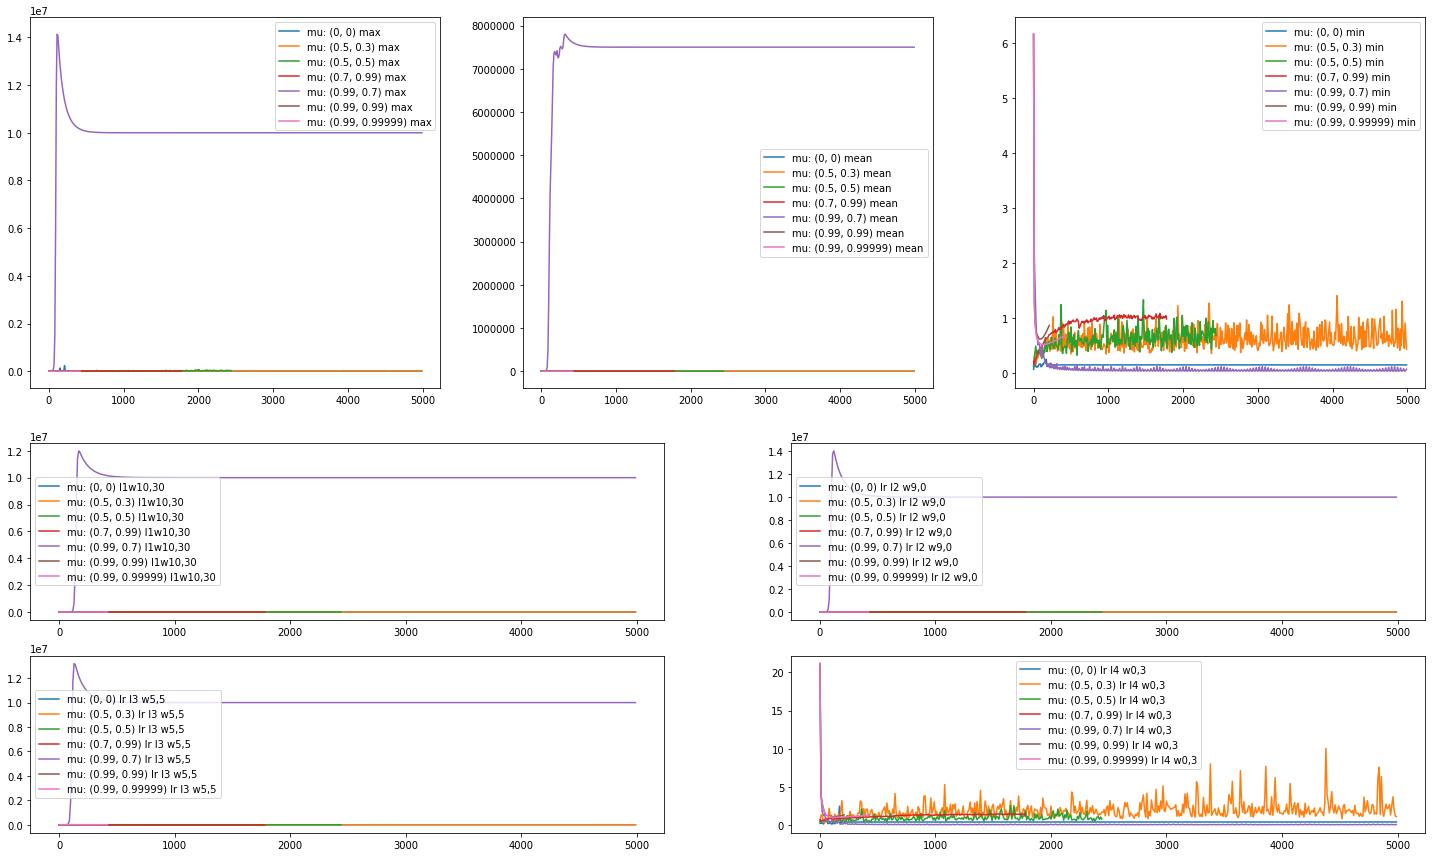

In [14]:
plt.figure(figsize=(25,15))
plt.subplot(4, 2, 5)
for num, i in enumerate(list_of_betas):
    plt.plot(epoch_list_by_rho[num], lr_l1_by_rho[num], label='mu: '+str(i)+' l1w10,30')
plt.legend()

plt.subplot(4, 2, 6)
for num, i in enumerate(list_of_betas):
    plt.plot(epoch_list_by_rho[num], lr_l2_by_rho[num], label='mu: '+str(i)+' lr l2 w9,0')
plt.legend()

plt.subplot(4, 2, 7)
for num, i in enumerate(list_of_betas):
    plt.plot(epoch_list_by_rho[num], lr_l3_by_rho[num], label='mu: '+str(i)+' lr l3 w5,5')
plt.legend()

plt.subplot(4, 2, 8)
for num, i in enumerate(list_of_betas):
    plt.plot(epoch_list_by_rho[num], lr_l4_by_rho[num], label='mu: '+str(i)+' lr l4 w0,3')
plt.legend()

plt.subplot(2, 3, 1)
for num, i in enumerate(list_of_betas):
    plt.plot(epoch_list_by_rho[num], lr_max_by_rho[num], label='mu: '+str(i)+' max')
plt.legend()

plt.subplot(2, 3, 2)
for num, i in enumerate(list_of_betas):
    plt.plot(epoch_list_by_rho[num], lr_mean_by_rho[num], label='mu: '+str(i)+' mean')
plt.legend()

plt.subplot(2, 3, 3)
for num, i in enumerate(list_of_betas):
    plt.plot(epoch_list_by_rho[num], lr_min_by_rho[num], label='mu: '+str(i)+' min')
plt.legend()

plt.legend()
plt.savefig('adamlrs.png', bbox_inches='tight')

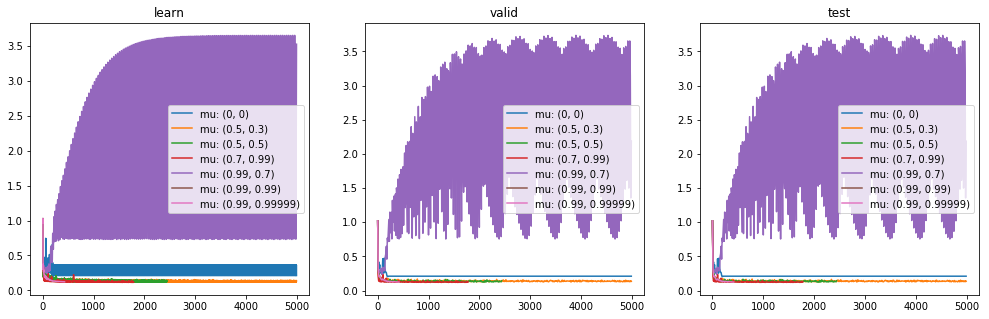

In [15]:
plt.figure(figsize=(17,5))
plt.subplot(1, 3, 1)
for num, i in enumerate(list_of_betas):
    plt.plot(learn_loss_by_rho[num], label='mu: '+str(i))
plt.legend()
plt.title('learn')

plt.subplot(1, 3, 2)
for num, i in enumerate(list_of_betas):
    plt.plot(epoch_list_by_rho[num], valid_loss_by_rho[num], label='mu: '+str(i))
plt.legend()
plt.title('valid')


plt.subplot(1, 3, 3)
for num, i in enumerate(list_of_betas):
    plt.plot(epoch_list_by_rho[num], test_loss_by_rho[num], label='mu: '+str(i))
plt.legend()
plt.title('test')


plt.legend()
plt.savefig('adamloss.png', bbox_inches='tight')

In [16]:
for i in learn_loss_by_rho:
    print(i[2])

0.45711007714271545
0.3324054181575775
0.32900962233543396
0.36142194271087646
0.4440567195415497
0.437335342168808
0.437124103307724


In [17]:
for i in test_loss_by_rho:
    print(i[2])

0.41939184069633484
0.20227645337581635
0.24334239959716797
0.13822601735591888
0.2811219096183777
0.22600214183330536
0.22672395408153534


In [18]:
list_of_betas = [(0, 0), (0.5, 0.3), (0.3, 0.5), (0.7, 0.99), (0.99, 0.7), (0.99, 0.99), (0.99, 0.99999)]

list_of_betas_without = [(0, 0), (0.5, 0.3), (0.3, 0.5), (0.99, 0.7)]





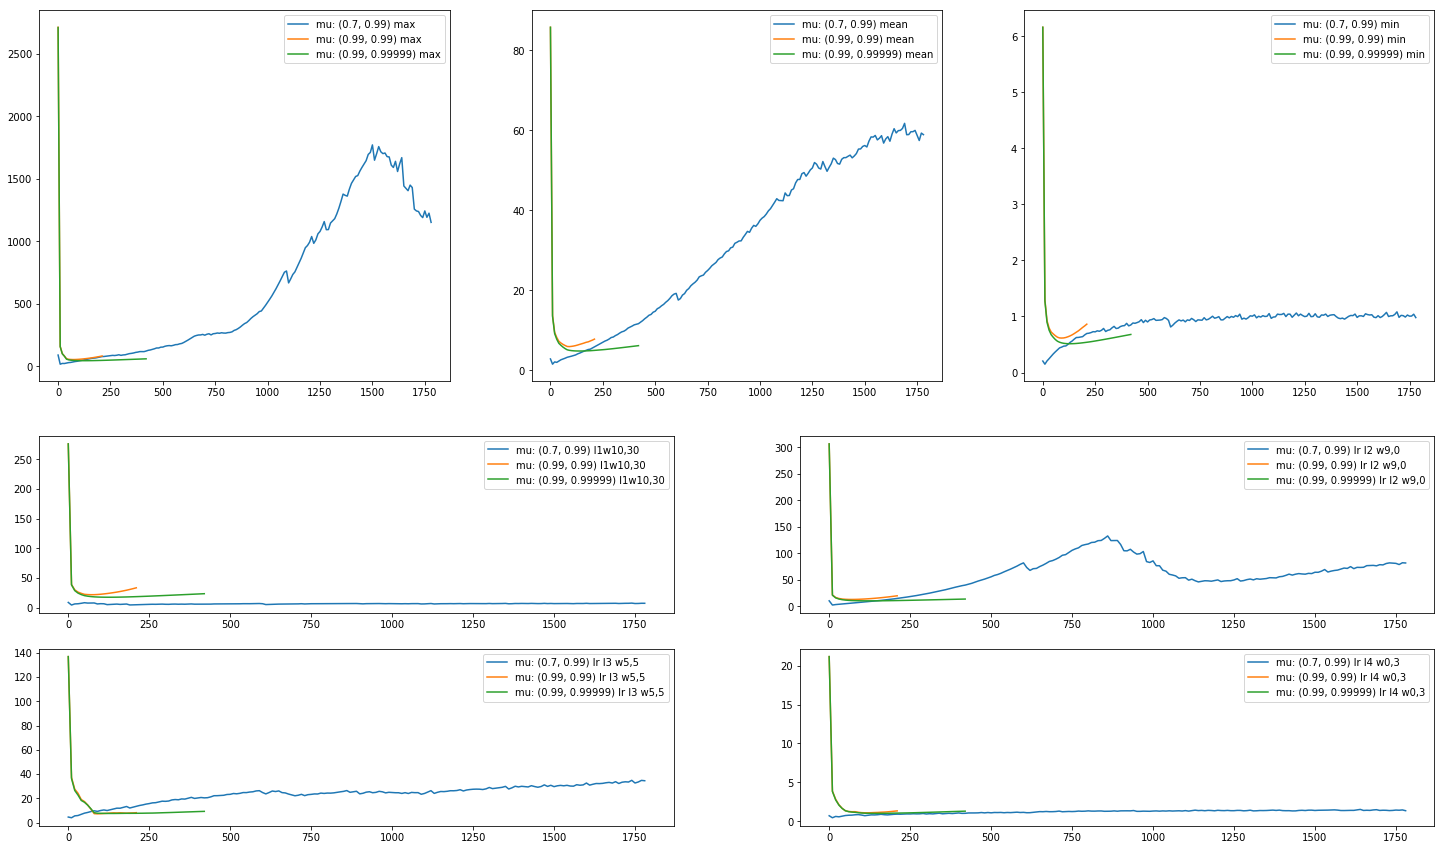

In [19]:
plt.figure(figsize=(25,15))
plt.subplot(4, 2, 5)
for num, i in enumerate(list_of_betas):
    if not(i in list_of_betas_without):
        plt.plot(epoch_list_by_rho[num], lr_l1_by_rho[num], label='mu: '+str(i)+' l1w10,30')
plt.legend()

plt.subplot(4, 2, 6)
for num, i in enumerate(list_of_betas):
    if not( i in list_of_betas_without):
        plt.plot(epoch_list_by_rho[num], lr_l2_by_rho[num], label='mu: '+str(i)+' lr l2 w9,0')
plt.legend()

plt.subplot(4, 2, 7)
for num, i in enumerate(list_of_betas):
    if not( i in list_of_betas_without):
        plt.plot(epoch_list_by_rho[num], lr_l3_by_rho[num], label='mu: '+str(i)+' lr l3 w5,5')
plt.legend()

plt.subplot(4, 2, 8)
for num, i in enumerate(list_of_betas):
    if not( i in list_of_betas_without):
        plt.plot(epoch_list_by_rho[num], lr_l4_by_rho[num], label='mu: '+str(i)+' lr l4 w0,3')
plt.legend()

plt.subplot(2, 3, 1)
for num, i in enumerate(list_of_betas):
    if not( i in list_of_betas_without):
        plt.plot(epoch_list_by_rho[num], lr_max_by_rho[num], label='mu: '+str(i)+' max')
plt.legend()

plt.subplot(2, 3, 2)
for num, i in enumerate(list_of_betas):
    if not( i in list_of_betas_without):
        plt.plot(epoch_list_by_rho[num], lr_mean_by_rho[num], label='mu: '+str(i)+' mean')
plt.legend()

plt.subplot(2, 3, 3)
for num, i in enumerate(list_of_betas):
    if not( i in list_of_betas_without):
        plt.plot(epoch_list_by_rho[num], lr_min_by_rho[num], label='mu: '+str(i)+' min')
plt.legend()

plt.legend()
plt.savefig('adam_without_lrs.png', bbox_inches='tight')

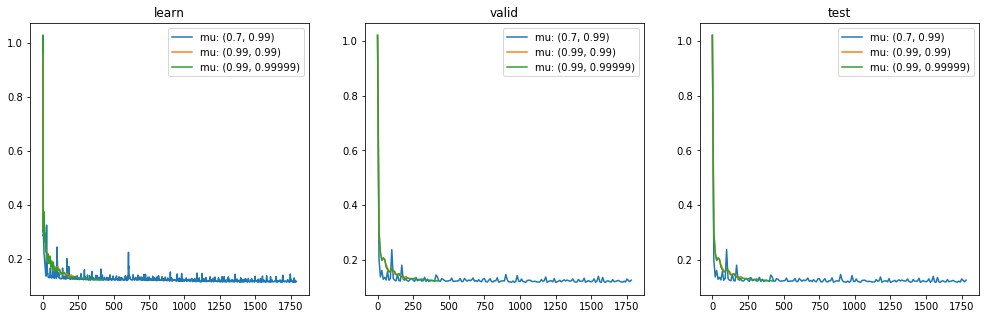

In [20]:
plt.figure(figsize=(17,5))
plt.subplot(1, 3, 1)
for num, i in enumerate(list_of_betas):
    if not( i in list_of_betas_without):
        plt.plot(learn_loss_by_rho[num], label='mu: '+str(i))
plt.legend()
plt.title('learn')

plt.subplot(1, 3, 2)
for num, i in enumerate(list_of_betas):
    if not( i in list_of_betas_without):
        plt.plot(epoch_list_by_rho[num], valid_loss_by_rho[num], label='mu: '+str(i))
plt.legend()
plt.title('valid')


plt.subplot(1, 3, 3)
for num, i in enumerate(list_of_betas):
    if not( i in list_of_betas_without):
        plt.plot(epoch_list_by_rho[num], test_loss_by_rho[num], label='mu: '+str(i))
plt.legend()
plt.title('test')


plt.legend()
plt.savefig('adam_without_loss.png', bbox_inches='tight')